# **Fine-Tuning di MobileNet**

In questo script, è stato effettuato il **fine-tuning di MobileNet**, anche questo un modello pre-addestrato su ImageNet.



## **Preprocessing del Dataset**
L'intero processo di preprocessing, bilanciamento delle classi, suddivisione del dataset in training, validation e test, e applicazione delle trasformazioni è stato mantenuto **identico** (eccetto per il bilanciamento del training, tutte le classi a 1000) a quello utilizzato per AlexNet.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

# Definizione del percorso del dataset scaricato
dataset_path = "/content/drive/MyDrive/KOA Dataset/archive"

os.chdir(f'{dataset_path}')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/KOA Dataset/archive'

### **Importazione delle librerie e fissaggio dei semi**


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models


from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay


# Fissa il seed per la riproducibilità
seed = 42  # Puoi scegliere un altro numero

# Fissa il seed per Python
random.seed(seed)

# Fissa il seed per NumPy
np.random.seed(seed)

# Fissa il seed per PyTorch
torch.manual_seed(seed)

# Se stai utilizzando una GPU, fissa anche il seed per CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Impostazioni per la riproducibilità su GPU
torch.backends.cudnn.deterministic = True

# Impostazione dei colori per i grafici utilizzando la colormap "viridis"
colors = plt.cm.viridis([0.1, 0.3, 0.5, 0.7, 0.9])  # 5 colori diversi (5 classi) equidistanti



# Disabilitare tutti i warning per migliorare la leggibilità dell'output
import warnings
warnings.filterwarnings("ignore")

# Elenco dei set di dati presenti (train, validation, test, auto-test)
sets = ["train", "val", "test", "auto_test"]

### **Unione set**


In [ ]:
# Unisco tutti i set in un unico dataset
all_images = []
all_labels = []

for set_name in sets:
    set_path = os.path.join(dataset_path, set_name)
    for class_label in os.listdir(set_path):
        class_path = os.path.join(set_path, class_label)
        images = os.listdir(class_path)
        all_images.extend([os.path.join(class_path, img) for img in images])
        all_labels.extend([int(class_label)] * len(images))

print(f"Numero totale di immagini: {len(all_images)}")
print(f"Numero totale di etichette: {len(all_labels)}")


Numero totale di immagini: 9786
Numero totale di etichette: 9786


### **Distribuzioni classi**


Distribuzione delle classi:
Classe 2: 2578 immagini
Classe 1: 1770 immagini
Classe 0: 3857 immagini
Classe 3: 1286 immagini
Classe 4: 295 immagini


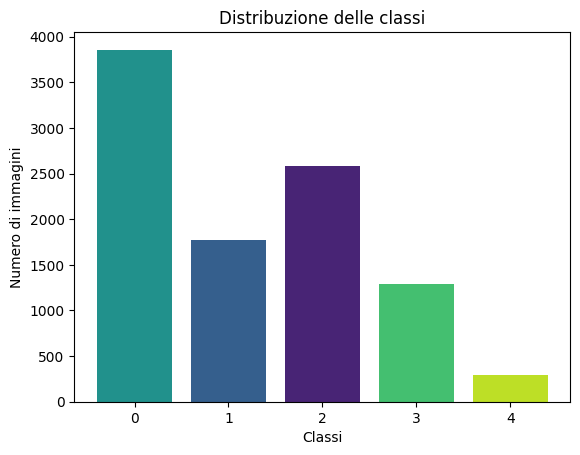

In [ ]:
# Controllo distribuzione delle classi
label_counts = Counter(all_labels)
print("Distribuzione delle classi:")
for label, count in label_counts.items():
    print(f"Classe {label}: {count} immagini")

# Visualizzazione delle statistiche
fig, ax = plt.subplots()
ax.bar(label_counts.keys(), label_counts.values(), color=colors)
ax.set_title("Distribuzione delle classi")
ax.set_xlabel("Classi")
ax.set_ylabel("Numero di immagini")
plt.xticks(list(label_counts.keys()))
plt.show()

### **Lettura delle Immagini**


In [ ]:
# Dataset con immagini e etichette
dataset = []

# Lettura delle immagini
for set_name in sets:
    set_path = os.path.join(dataset_path, set_name)
    for class_label in os.listdir(set_path):
        class_path = os.path.join(set_path, class_label)
        images = os.listdir(class_path)
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            # Leggi l'immagine con OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Scala di grigi

            # ROI
            roi = img[48:-48, 10:-10]

            # Equalizzare l'istogramma
            equalized = cv2.equalizeHist(roi)

            # Ridimensionare l'immagine a 224x224 (richiesto come input di AlexNet)
            equalized = cv2.resize(equalized, (224, 224), interpolation=cv2.INTER_AREA)

            # Convertire l'immagine in scala di grigi in un'immagine con 3 canali (richiesto come input di AlexNet)
            image = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)

            dataset.append((image, int(class_label)))

images, labels = zip(*dataset)

###**Splitting del Dataset**


In [ ]:
# Percentuale del validation e test set
validation_size = 0.10
test_size = 0.10


# Split stratificato tra train e test
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels,
    test_size=test_size,
    stratify=labels,
    random_state=42
)

# Split stratificato tra train e validation
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=validation_size,
    stratify=train_labels,
    random_state=42
)

# Verifica delle dimensioni
print(f"Immagini per il training: {len(train_images)}")
print(f"Immagini per la validazione: {len(val_images)}")
print(f"Immagini per il test: {len(test_images)}")


Immagini per il training: 7926
Immagini per la validazione: 881
Immagini per il test: 979


In [ ]:
import PIL

# Trasformazioni per l'addestramento e la validazione
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Converte l'immagine in un'immagine PIL (serve per ToTensor)
    transforms.ToTensor(),  # Converte l'immagine in tensore PyTorch e normalizza i valori in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione
])

validation_transforms = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in tensore PyTorch e normalizza i valori in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Converte l'immagine in tensore PyTorch e normalizza i valori in [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizzazione
])

# Dataset personalizzati per Train e Test
class KneeOsteoarthritisDataset(Dataset):
    def __init__(self, image, labels, transform=None):
        self.image = image
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### **Class Unbalancing, Downsampling e Data Augmentation**


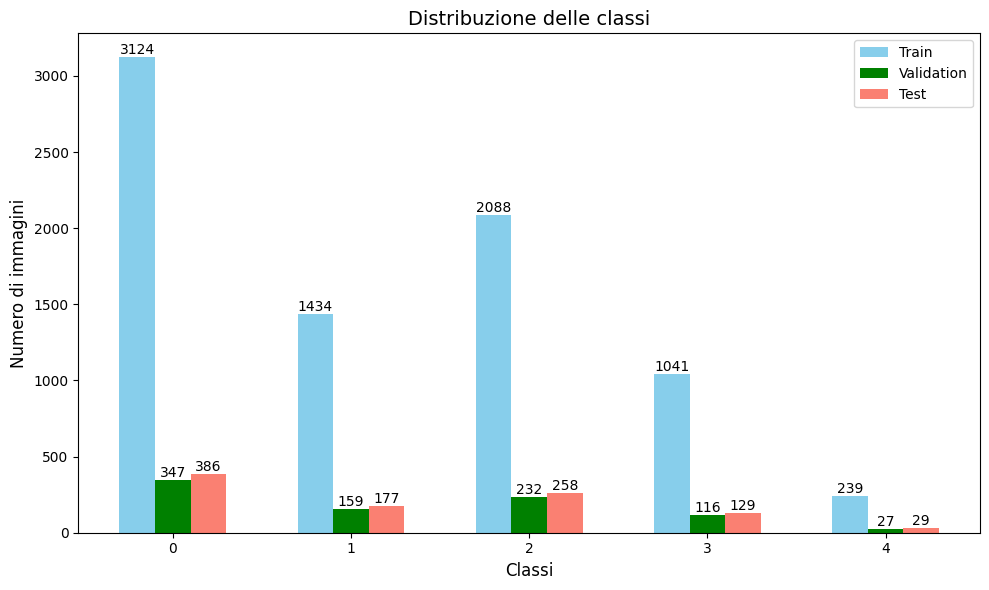

In [ ]:
# Contare le classi nel train, validation e test set
train_label_counts = Counter(train_labels)
val_label_counts = Counter(val_labels)
test_label_counts = Counter(test_labels)

# Creare un array per tutte le classi
classes = sorted(list(train_label_counts.keys()))  # Ordina le classi per sicurezza

# Larghezza delle barre
width = 0.2

# Posizioni delle barre
x = np.arange(len(classes))  # Posizioni base

x_train = x - width  # Barre per il train set
x_val = x            # Barre per il validation set
x_test = x + width   # Barre per il test set

# Creare il barplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot del train set
train_bar = ax.bar(x_train, [train_label_counts[cls] for cls in classes],
                   color="skyblue", width=width, label="Train")

# Plot del validation set
val_bar = ax.bar(x_val, [val_label_counts.get(cls, 0) for cls in classes],
                 color="green", width=width, label="Validation")

# Plot del test set
test_bar = ax.bar(x_test, [test_label_counts.get(cls, 0) for cls in classes],
                  color="salmon", width=width, label="Test")

# Aggiungere i numeri sopra le barre
for bars in [train_bar, val_bar, test_bar]:
    for rect in bars:
        height = rect.get_height()
        if height > 0:  # Mostra il numero solo per barre con altezza > 0
            ax.text(rect.get_x() + rect.get_width() / 2, height,
                    f'{height}', ha='center', va='bottom', fontsize=10)

# Imposta titolo e assi
ax.set_title("Distribuzione delle classi", fontsize=14)
ax.set_xlabel("Classi", fontsize=12)
ax.set_ylabel("Numero di immagini", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Funzione per l'augmentazione delle immagini (flip e rotazione) usando OpenCV
def augment_images(images, max_count=1000):
    augmented_images = images[:]

    # Flip left-right usando OpenCV
    def flip_left_right(image):
        return cv2.flip(image, 1)

    # Controlliamo quante immagini abbiamo dopo il flip
    while len(augmented_images) < max_count:
        for img in images:
            flipped = flip_left_right(img)
            augmented_images.append(flipped)

            if len(augmented_images) >= max_count:
                break

    # Se non abbiamo ancora raggiunto il numero massimo, applichiamo la rotazione
    if len(augmented_images) < max_count:
        for img in images:
            angle = random.uniform(-10, 10)  # Angolo casuale tra -10 e +10 gradi
            height, width = img.shape[:2]
            center = (width // 2, height // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(img, rotation_matrix, (width, height))
            augmented_images.append(rotated)

            if len(augmented_images) >= max_count:
                break

    return augmented_images[:max_count]


# Filtrare le immagini per le classi 3 e 4
class_3_images = [img for img, label in zip(train_images, train_labels) if label == 3]
class_4_images = [img for img, label in zip(train_images, train_labels) if label == 4]

# Eseguire downsampling per le classi 0 e 2 (come fatto prima)
class_0_images = [img for img, label in zip(train_images, train_labels) if label == 0]
class_1_images = [img for img, label in zip(train_images, train_labels) if label == 1]
class_2_images = [img for img, label in zip(train_images, train_labels) if label == 2]

class_0_images = random.sample(class_0_images, 1000)
class_2_images = random.sample(class_2_images, 1000)

# Eseguire augmentazione per le classi 1,3 e 4
augmented_class_1_images = augment_images(class_1_images, max_count=1000)
augmented_class_3_images = augment_images(class_3_images, max_count=1000)
augmented_class_4_images = augment_images(class_4_images, max_count=1000)

# Unire le immagini selezionate per tutte le classi (downsampling + augmentazione)
downsampled_train_images = class_0_images + augmented_class_1_images + class_2_images + augmented_class_3_images + augmented_class_4_images

# Creare le etichette corrispondenti
downsampled_train_labels = [0] * len(class_0_images) + [1] * len(augmented_class_1_images) + [2] * len(class_2_images) + [3] * len(augmented_class_3_images) + [4] * len(augmented_class_4_images)

# Controllare il numero totale di immagini dopo il downsampling e augmentazione
print(f"Numero totale di immagini nel train set dopo downsampling e augmentazione: {len(downsampled_train_images)}")

# Creare il dataset di addestramento con il downsampling e augmentazione
train_dataset_downsampled_augmented = KneeOsteoarthritisDataset(downsampled_train_images, downsampled_train_labels, transform=train_transforms)

Numero totale di immagini nel train set dopo downsampling e augmentazione: 5000


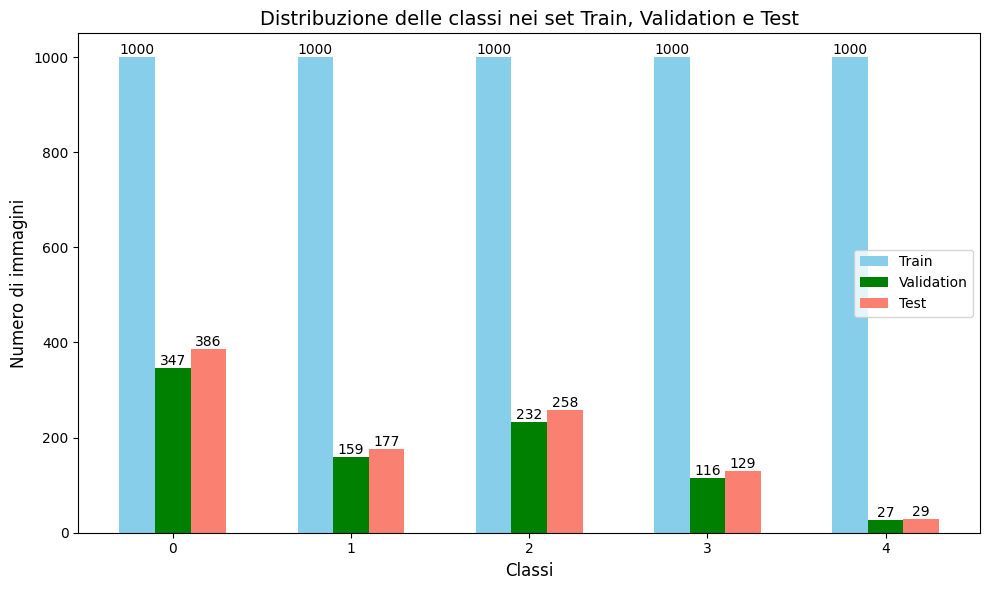

In [ ]:
# Contare le etichette nel train set (con downsampling e augmentazione)
downsampled_train_label_counts = Counter(downsampled_train_labels)

# Contare le etichette nel validation set
val_label_counts = Counter(val_labels)

# Contare le etichette nel test set
test_label_counts = Counter(test_labels)

# Creare un array per tutte le classi
classes = sorted(list(downsampled_train_label_counts.keys()))  # Ordina le classi per sicurezza

# Larghezza delle barre
width = 0.2

# Posizioni delle barre
x = np.arange(len(classes))  # Posizioni base

# Posizione delle barre
x_train = x - width  # Barre per il train set
x_val = x            # Barre per il validation set
x_test = x + width   # Barre per il test set

# Creare il barplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot del train set (con downsampling e augmentazione)
train_bar = ax.bar(x_train, [downsampled_train_label_counts[cls] for cls in classes],
                   color="skyblue", width=width, label="Train")

# Plot del validation set
val_bar = ax.bar(x_val, [val_label_counts.get(cls, 0) for cls in classes],
                 color="green", width=width, label="Validation")

# Plot del test set
test_bar = ax.bar(x_test, [test_label_counts.get(cls, 0) for cls in classes],
                  color="salmon", width=width, label="Test")

# Aggiungere i numeri sopra le barre
for bars in [train_bar, val_bar, test_bar]:
    for rect in bars:
        height = rect.get_height()
        if height > 0:  # Mostra il numero solo per barre con altezza > 0
            ax.text(rect.get_x() + rect.get_width() / 2, height,
                    f'{height}', ha='center', va='bottom', fontsize=10)

# Impostare titolo e assi
ax.set_title("Distribuzione delle classi nei set Train, Validation e Test", fontsize=14)
ax.set_xlabel("Classi", fontsize=12)
ax.set_ylabel("Numero di immagini", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()

### **Creazione dei Data Loader**


In [ ]:
# Dataset
train_dataset = KneeOsteoarthritisDataset(downsampled_train_images, downsampled_train_labels, transform=train_transforms)
val_dataset = KneeOsteoarthritisDataset(val_images, val_labels, transform=validation_transforms)
test_dataset = KneeOsteoarthritisDataset(test_images, test_labels, transform=test_transforms)

# Creazione dei DataLoader per Train, Validation e Test
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Modello
Il modello è stato scaricato direttamente con i suoi **pesi pre-addestrati** su ImageNet, impostando `pretrained=True`.

#### Adattamento del modello al task specifico
Analizzando la struttura del modello MobileNet, si è osservato che:

1. **Input a tre canali**:
   - Il primo layer convoluzionale richiede immagini con **3 canali (RGB)** come input, una caratteristica che è stata considerata nel preprocessing, dove le immagini in scala di grigi sono state convertite a RGB.

2. **Output a 1000 classi**:
   - Il layer finale in configurazione originale è progettato per classificare 1000 classi presenti nel dataset ImageNet. Poiché il task attuale richiede di classificare le immagini in **5 classi**, questo layer è stato modificato. In particolare, il **fully connected layer finale** è stato sostituito con un layer che produce un output di 5 unità.

Questa modifica consente di utilizzare MobileNet come base per il fine tuning successivo, sfruttando le caratteristiche già apprese sul dataset ImageNet e adattandole al problema specifico, con una significativa riduzione del tempo di addestramento e del rischio di overfitting.

In [ ]:
# Struttura di MobileNet pre-addestrata
mobilenet = models.mobilenet_v3_large(pretrained=True) # si è scelta l'ultima versione con le maggiori dimensioni
print(mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
# Modifica l'output per avere 5 classi (1 per ogni grado di severità)
mobilenet.classifier[3] = nn.Linear(in_features=1280, out_features=5)

# Verifica la struttura del modello
print(mobilenet)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

### Preparazione per il Fine-Tuning
A differenza del fine-tuning di Alexnet, per questa rete sono stati sbloccati solo i layer lineari (classificatore), a causa dell'eccesivo tempo per ogni epoca (risorse computazionali limitate). 


In [ ]:
# Congelo i pesi di tutti i layer tranne il primo e l'ultimo
for param in mobilenet.features.parameters():
    param.requires_grad = False
for param in mobilenet.classifier.parameters(): # Sblocco tutto il classificatore
    param.requires_grad = True

In [ ]:
for name, param in mobilenet.named_parameters():
    print(f"{name}: {param.requires_grad}")

features.0.0.weight: False
features.0.1.weight: False
features.0.1.bias: False
features.1.block.0.0.weight: False
features.1.block.0.1.weight: False
features.1.block.0.1.bias: False
features.1.block.1.0.weight: False
features.1.block.1.1.weight: False
features.1.block.1.1.bias: False
features.2.block.0.0.weight: False
features.2.block.0.1.weight: False
features.2.block.0.1.bias: False
features.2.block.1.0.weight: False
features.2.block.1.1.weight: False
features.2.block.1.1.bias: False
features.2.block.2.0.weight: False
features.2.block.2.1.weight: False
features.2.block.2.1.bias: False
features.3.block.0.0.weight: False
features.3.block.0.1.weight: False
features.3.block.0.1.bias: False
features.3.block.1.0.weight: False
features.3.block.1.1.weight: False
features.3.block.1.1.bias: False
features.3.block.2.0.weight: False
features.3.block.2.1.weight: False
features.3.block.2.1.bias: False
features.4.block.0.0.weight: False
features.4.block.0.1.weight: False
features.4.block.0.1.bias: 

## **Training e Validation**


In [ ]:
# Definizione del dispositivo (GPU se disponibile, altrimenti CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

# Definizione della funzione di perdita
criterion = nn.CrossEntropyLoss()

# Creiamo una lista di parametri per ciascun gruppo (classificatore, ultimi due layer convoluzionali)
params_to_update = [{'params': mobilenet.classifier.parameters(), 'lr': 1e-4}]

# Creiamo l'ottimizzatore con regolarizzazione L2
optimizer = optim.Adam(params_to_update, weight_decay=1e-5)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early Stopping
best_val_loss = float('inf')  # Perdita di validazione migliore
patience = 6  # Numero massimo di epoche senza miglioramenti
epochs_without_improvement = 0


In [ ]:
# Numero di epoche
num_epochs = 30

# Salva la perdita e l'accuratezza per il training e la validazione
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Loop di addestramento
for epoch in range(num_epochs):
    mobilenet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validazione
    mobilenet.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Scheduler step
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(mobilenet.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}%")

Epoch 1/30, Train Loss: 1.3926, Train Acc: 37.40%, Validation Loss: 1.3835, Validation Acc: 33.60%
Epoch 2/30, Train Loss: 1.2511, Train Acc: 45.20%, Validation Loss: 1.3056, Validation Acc: 40.75%
Epoch 3/30, Train Loss: 1.1920, Train Acc: 48.14%, Validation Loss: 1.2555, Validation Acc: 42.11%
Epoch 4/30, Train Loss: 1.1559, Train Acc: 49.74%, Validation Loss: 1.3095, Validation Acc: 41.32%
Epoch 5/30, Train Loss: 1.1297, Train Acc: 51.40%, Validation Loss: 1.2574, Validation Acc: 40.86%
Epoch 6/30, Train Loss: 1.0894, Train Acc: 53.86%, Validation Loss: 1.2239, Validation Acc: 44.49%
Epoch 7/30, Train Loss: 1.0760, Train Acc: 54.46%, Validation Loss: 1.2718, Validation Acc: 39.27%
Epoch 8/30, Train Loss: 1.0400, Train Acc: 56.52%, Validation Loss: 1.2594, Validation Acc: 43.93%
Epoch 9/30, Train Loss: 1.0311, Train Acc: 57.60%, Validation Loss: 1.2517, Validation Acc: 44.38%
Epoch 10/30, Train Loss: 1.0151, Train Acc: 58.02%, Validation Loss: 1.2352, Validation Acc: 43.93%
Epoch 11/

### **Curve di Loss e Accuracy**



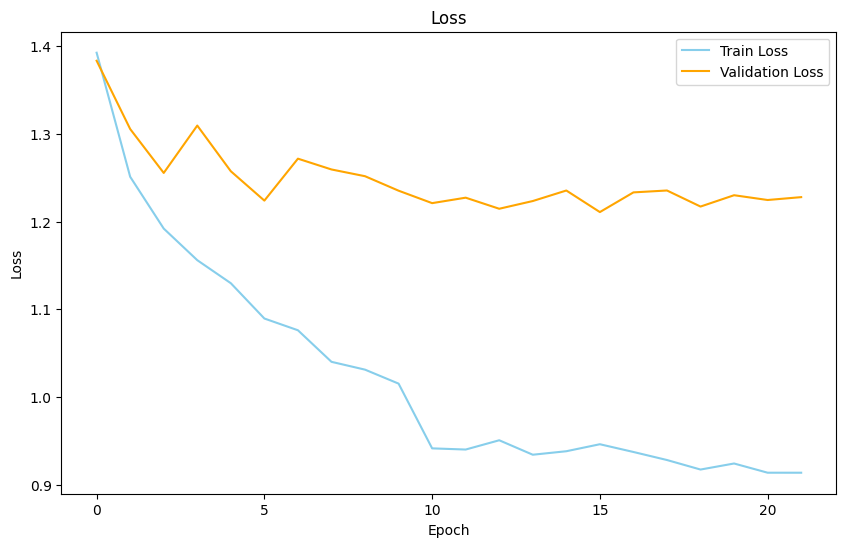

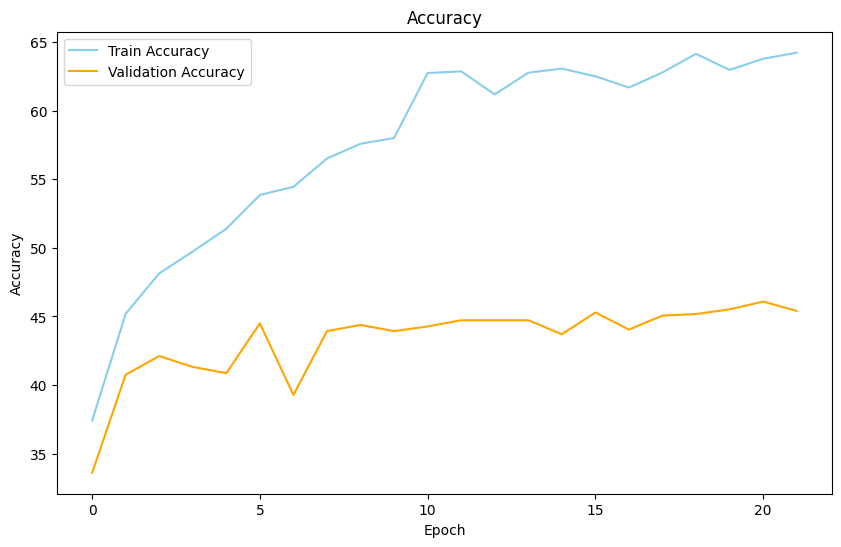

In [ ]:
# Plot della perdita
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", color="skyblue")
plt.plot(val_losses, label="Validation Loss", color="orange")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot dell'accuratezza
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label="Train Accuracy", color="skyblue")
plt.plot(val_accuracies, label="Validation Accuracy", color="orange")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### **Test**


Test Loss: 1.1830, Test Acc: 48.11%


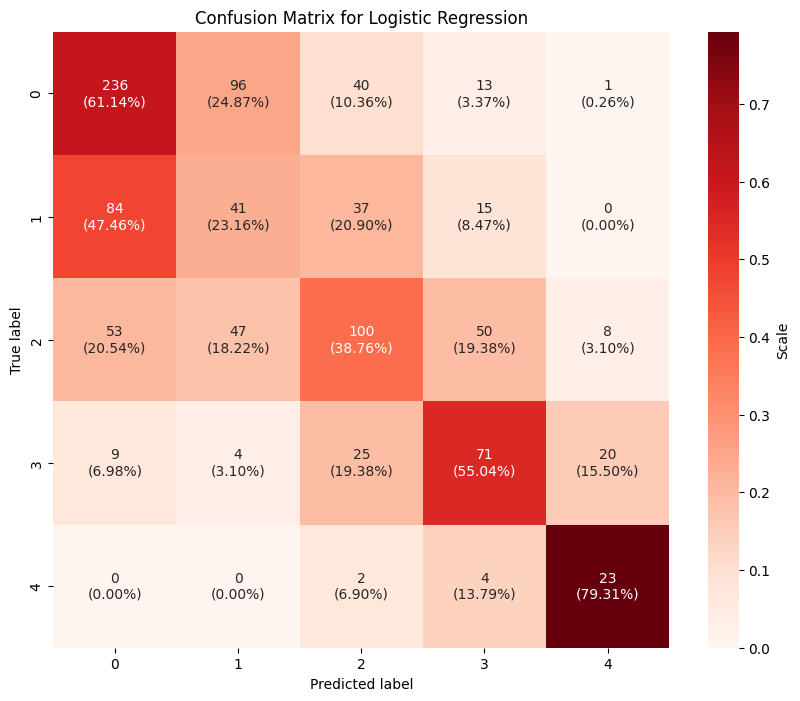

In [ ]:
from sklearn.metrics import confusion_matrix

# Carica il miglior modello salvato
mobilenet.load_state_dict(torch.load('best_model.pth'))
mobilenet.to(device)

from sklearn.metrics import confusion_matrix
import seaborn as sns


# Test
mobilenet.eval()
test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:  # Assicurati di avere un DataLoader per il test
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Aggiungi le etichette e le predizioni alle liste
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcola la loss e l'accuratezza
test_loss = test_loss / len(test_loader)
test_accuracy = 100. * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# Calcola la matrice di confusione
cm = confusion_matrix(all_labels, all_predictions)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_norm[i, j] * 100
        s = f"{c}\n({p:.2f}%)"
        annot[i, j] = s

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Reds', cbar_kws={'label': 'Scale'}, ax=ax, square=True)
ax.set_title('Confusion Matrix for Logistic Regression')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

- I risultati peggiori rispetto ad AlexNet molto probabilmente potrebbero essere dovuti al fatto che non sono stati sbloccati layer convoluzionali come fatto invece per l'altra rete.
Questo dimostra che le features **generali** già presenti (quelle calcolate su ImageNet) non sono sufficienti per il task richiesto.
Ho provato a sbloccare anche qui tali layer, ma essendo una rete ben più complessa e grande rispetto ad AlexNet ogni epoca durava troppo.
- Nonostante ciò l'accuracy sul test è più alta rispetto a quella sui modelli classici allenati con handcrafted features dimostrando come anche solo le features intrinseche del modello preaddestrato bastino a superare le performance dei classici modelli studiati per la classificazione di dati strutturati (dati tabulari).